# Part 2: Data Analysis of Reddit Data

### Importing necessary libraries

In [1]:

# Data Manipulation 
import numpy as np 
import pandas as pd 
#pd.options.mode.chained_assignment = None 

# Text Manipulation 
import re 
import nltk 
from gensim.models import word2vec

# Data Visualisation 
import matplotlib.pyplot as plt 
import seaborn as sns

In [4]:
# Load the data into a dataframe 
data = pd.read_csv('data.csv')
data.shape

(1000, 11)

In [5]:
# Data Shuffling
data.drop(['Unnamed: 0'], inplace=True, axis=1)
data[:] = data.sample(frac=1).values
data.head()

,Title,Score,ID,URL,num_comments,created_on,Body,Original,Flair,Comments
0,COVID-19 fear delaying cancer care in India: O...,32,k9sbju,https://www.india.com/lifestyle/covid-19-fear-...,2,1.607551e+09,NaN,False,Coronavirus,The fear of contracting COVID 19 has kept peop...
1,66 grandmasters and counting: The story behind...,326,hv88vu,https://www.espn.com/chess/story/_/id/29501703...,59,1.595370e+09,NaN,False,Sports,But we also need to focus on some other sports...
2,It’s High Time that India Reclaimed Its Ganja ...,116,jn3gu7,https://science.thewire.in/the-sciences/oshaug...,27,1.604405e+09,NaN,False,Science/Technology,Yes please.
3,Indian economy witnessing V-shaped recovery,30,k5uk7s,https://www.financialexpress.com/economy/india...,12,1.607019e+09,NaN,False,Policy/Economy,V for Wanakkam
4,Should I measure my foods cooked or uncooked?,12,k3sklo,https://www.reddit.com/r/india/comments/k3sklo...,4,1.606757e+09,"Hello guys, as the title says, I had a big do...",False,Food,where are you getting your nutritional informa...


In [6]:
# Display data types and null values
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Title         1000 non-null   object 
 1   Score         1000 non-null   int64  
 2   ID            1000 non-null   object 
 3   URL           1000 non-null   object 
 4   num_comments  1000 non-null   int64  
 5   created_on    1000 non-null   float64
 6   Body          340 non-null    object 
 7   Original      1000 non-null   bool   
 8   Flair         1000 non-null   object 
 9   Comments      959 non-null    object 
dtypes: bool(1), float64(1), int64(2), object(6)
memory usage: 71.4+ KB


In [7]:
print(len(data['Flair'].unique()))
data['Flair'].unique()

10


array(['Coronavirus', 'Sports', 'Science/Technology', 'Policy/Economy',
       'Food', 'AskIndia', 'Non-Political', '[R]eddiquette',
       'Business/Finance', 'Photography'], dtype=object)

In [8]:
# List of relevant features (Ones containing the right type of textual data for classification)
features = ['Flair', 'URL', 'Title', 'Comments', 'Body']
data = data[features]
data.head()

,Flair,URL,Title,Comments,Body
0,Coronavirus,https://www.india.com/lifestyle/covid-19-fear-...,COVID-19 fear delaying cancer care in India: O...,The fear of contracting COVID 19 has kept peop...,NaN
1,Sports,https://www.espn.com/chess/story/_/id/29501703...,66 grandmasters and counting: The story behind...,But we also need to focus on some other sports...,NaN
2,Science/Technology,https://science.thewire.in/the-sciences/oshaug...,It’s High Time that India Reclaimed Its Ganja ...,Yes please.,NaN
3,Policy/Economy,https://www.financialexpress.com/economy/india...,Indian economy witnessing V-shaped recovery,V for Wanakkam,NaN
4,Food,https://www.reddit.com/r/india/comments/k3sklo...,Should I measure my foods cooked or uncooked?,where are you getting your nutritional informa...,"Hello guys, as the title says, I had a big do..."


In [9]:
# Assigning and individual id to each flair
data['id'] = data['Flair'].factorize()[0]
flair_category = data[['Flair', 'id']].drop_duplicates().sort_values('id')
flair_category

,Flair,id
0,Coronavirus,0
1,Sports,1
2,Science/Technology,2
3,Policy/Economy,3
4,Food,4
5,AskIndia,5
9,Non-Political,6
15,[R]eddiquette,7
17,Business/Finance,8
51,Photography,9


In [10]:
# Convert into a label dictionary 
category_labels = dict(flair_category.values)
print(category_labels)

print("======="*15) # Line break display

# Similarly, we can create an inverse of the previous one to convert labels to categories
category_reverse = dict(flair_category[['id', 'Flair']].values)
print(category_reverse)

{'Coronavirus': 0, 'Sports': 1, 'Science/Technology': 2, 'Policy/Economy': 3, 'Food': 4, 'AskIndia': 5, 'Non-Political': 6, '[R]eddiquette': 7, 'Business/Finance': 8, 'Photography': 9}
{0: 'Coronavirus', 1: 'Sports', 2: 'Science/Technology', 3: 'Policy/Economy', 4: 'Food', 5: 'AskIndia', 6: 'Non-Political', 7: '[R]eddiquette', 8: 'Business/Finance', 9: 'Photography'}


In [11]:
# Creating a combined feature that is combination of the Title, Body and Comments. 
data['Combine'] = data['Title'] # Create a column combined
count = 0
for i in range(len(data)):
    if type(data.loc[i]['Body']) != float:
        data['Combine'][i] = data['Combine'][i] + ' ' + data['Body'][i]

    if type(data.loc[i]['Comments']) != float:
        data['Combine'][i] = data['Combine'][i] + ' ' + data['Comments'][i]

data.head(20)

<ipython-input-11-9aa9db37b9ca>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Combine'][i] = data['Combine'][i] + ' ' + data['Comments'][i]
<ipython-input-11-9aa9db37b9ca>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Combine'][i] = data['Combine'][i] + ' ' + data['Body'][i]


,Flair,URL,Title,Comments,Body,id,Combine
0,Coronavirus,https://www.india.com/lifestyle/covid-19-fear-...,COVID-19 fear delaying cancer care in India: O...,The fear of contracting COVID 19 has kept peop...,NaN,0,COVID-19 fear delaying cancer care in India: O...
1,Sports,https://www.espn.com/chess/story/_/id/29501703...,66 grandmasters and counting: The story behind...,But we also need to focus on some other sports...,NaN,1,66 grandmasters and counting: The story behind...
2,Science/Technology,https://science.thewire.in/the-sciences/oshaug...,It’s High Time that India Reclaimed Its Ganja ...,Yes please.,NaN,2,It’s High Time that India Reclaimed Its Ganja ...
3,Policy/Economy,https://www.financialexpress.com/economy/india...,Indian economy witnessing V-shaped recovery,V for Wanakkam,NaN,3,Indian economy witnessing V-shaped recovery V ...
4,Food,https://www.reddit.com/r/india/comments/k3sklo...,Should I measure my foods cooked or uncooked?,where are you getting your nutritional informa...,"Hello guys, as the title says, I had a big do...",4,Should I measure my foods cooked or uncooked? ...
5,AskIndia,https://www.reddit.com/r/india/comments/k70dkk...,'Swadeshi' products are lazy and made just for...,Umm yeah...\n\nBefore innovation comes a count...,Amongst the 'boycott china' craze (because we ...,5,'Swadeshi' products are lazy and made just for...
6,AskIndia,https://www.reddit.com/r/india/comments/k7r48n...,"how can I as an ordinary citizen, support the ...",Try to buy products from real cooperatives lik...,I have seen in videos how hard is for them to ...,5,"how can I as an ordinary citizen, support the ..."
7,Sports,https://timesofindia.com/sports/tennis/us-open...,Sumit Nagal becomes first Indian to win a Gran...,Wait he defeated Nadal/Federer?,NaN,1,Sumit Nagal becomes first Indian to win a Gran...
8,Coronavirus,https://timesofindia.indiatimes.com/india/astr...,AstraZeneca manufacturing error clouds vaccine...,AstraZeneca and Oxford University have acknow...,NaN,0,AstraZeneca manufacturing error clouds vaccine...
9,Non-Political,https://v.redd.it/f4fchsepmex51,Hyderabad cop running for 2 km to help ambulan...,Bhagwan zinda hain,NaN,6,Hyderabad cop running for 2 km to help ambulan...


## DATA CLEANING
### Stopword Removal

Let's make a list of all STOPWORDS to clean the text data. To make searching faster, we only download the stopwords from the english language. Definition: Stopwords are the English words which does not add much meaning to a sentence. They can safely be ignored without sacrificing the meaning of the sentence.

In [12]:
nltk.download('stopwords')
STOPWORDS = nltk.corpus.stopwords.words('english')
# Have a look at the various stopwords
print(STOPWORDS)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\kirtiksingh\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Define a cleaning function to pass our features through for cleaning them.


In [13]:
REPLACE_SPACES = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS = re.compile('[^0-9a-z #+_]')

def clean_text(text):
    '''
        text: a string
        return: modified initial string
    '''

    text = text.lower() # lowercase text
    text = REPLACE_SPACES.sub(' ', text) 
    text = BAD_SYMBOLS.sub('', text) # Replace Bad Symbols which 
    text = text.replace('x', '')
    
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # remove stopwors from text
    return text

data['Combine'] = data['Combine'].apply(clean_text)
data['Combine'] = data['Combine'].str.replace('\d+', '')
data['Combine'].head(10)

0    covid fear delaying cancer care india  patient...
1     grandmasters counting story behind indias che...
2    high time india reclaimed ganja wire science y...
3    indian economy witnessing vshaped recovery v w...
4    measure foods cooked uncooked hello guys title...
5    swadeshi products lazy made quick buck amongst...
6    ordinary citizen support farmer seen videos ha...
7    sumit nagal becomes first indian win grand sla...
8    astrazeneca manufacturing error clouds vaccine...
9    hyderabad cop running  km help ambulance get t...
Name: Combine, dtype: object

In [20]:
data.shape

(1000, 7)

In [14]:
# Let's look at the number of empty columns
data.isnull().sum()

Flair         0
URL           0
Title         0
Comments     41
Body        660
id            0
Combine       0
dtype: int64

We can see that the body column is empty in 660 out of 1000 rows. We cannot impute this value either because it can have paragraphs. The url feature redirects to the article where the body is missing we can always scrape that, however, doesn't seem like it will help much and it is going to be more difficult to automate the collection of self_text from these external websites. We can get a jist of the content mainly from the title and we can use it for our models. Going forward, I will get rid of the body column but I can still use it for my data analysis section. 

## Data Cleaning and Preparation

In this section, I will be removing unnecessary words, cleaning the dataset and individual sentences. I will also be creating a corpus for further analyses. A corpus is a list containing split() sentences and each word can be accounted for. I will aslo be checking the data quality for any inconsistency and accuracy.

In [21]:
data.columns

Index(['Flair', 'URL', 'Title', 'Comments', 'Body', 'id', 'Combine'], dtype='object')

In [22]:
data.head()

,Flair,URL,Title,Comments,Body,id,Combine
0,Coronavirus,https://www.india.com/lifestyle/covid-19-fear-...,COVID-19 fear delaying cancer care in India: O...,The fear of contracting COVID 19 has kept peop...,NaN,0,covid fear delaying cancer care india patient...
1,Sports,https://www.espn.com/chess/story/_/id/29501703...,66 grandmasters and counting: The story behind...,But we also need to focus on some other sports...,NaN,1,grandmasters counting story behind indias che...
2,Science/Technology,https://science.thewire.in/the-sciences/oshaug...,It’s High Time that India Reclaimed Its Ganja ...,Yes please.,NaN,2,high time india reclaimed ganja wire science y...
3,Policy/Economy,https://www.financialexpress.com/economy/india...,Indian economy witnessing V-shaped recovery,V for Wanakkam,NaN,3,indian economy witnessing vshaped recovery v w...
4,Food,https://www.reddit.com/r/india/comments/k3sklo...,Should I measure my foods cooked or uncooked?,where are you getting your nutritional informa...,"Hello guys, as the title says, I had a big do...",4,measure foods cooked uncooked hello guys title...


To begin with, the coulmn 'unnamed' has come due to index inconsistencies and is of no use to our analysis. Similarly, the columns of ID and subreddit are also not useful since we already know that there is only one subreddit tag. 

### Flair Data Analysis

In [24]:
# Let's review the different Flairs
data['Flair'].unique()

array(['Coronavirus', 'Sports', 'Science/Technology', 'Policy/Economy',
       'Food', 'AskIndia', 'Non-Political', '[R]eddiquette',
       'Business/Finance', 'Photography'], dtype=object)

In [25]:
data['Flair'].value_counts()

Photography           100
AskIndia              100
[R]eddiquette         100
Business/Finance      100
Sports                100
Policy/Economy        100
Non-Political         100
Coronavirus           100
Food                  100
Science/Technology    100
Name: Flair, dtype: int64

<AxesSubplot:>

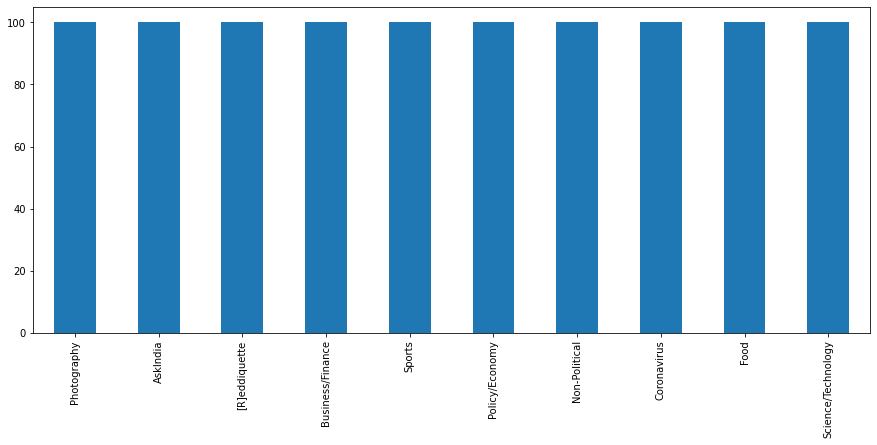

In [26]:
data['Flair'].value_counts().plot.bar(figsize=(15, 6))

In [27]:
# Let's impute the flair null value
data[data['Flair'].isnull()]

,Flair,URL,Title,Comments,Body,id,Combine


In [28]:
data.loc[(data['Flair'] == '/r/all') | (data['Flair'] == 'r/all'),  'Flair'] = 'r/all'
data.loc[(data['Flair'] == 'Politics') | (data['Flair'] == 'Politics [Megathread]') | (data['Flair'] == 'Politics -- Source in comments'),  'Flair'] = 'Politics' 
data.loc[(data['Flair'] == 'CAA-NRC-NPR') | (data['Flair'] == 'CAA-NRC'),  'Flair'] = 'CAA-NRC'
data.loc[(data['Flair'] == 'Misleading') | (data['Flair'] == 'Misleading Headline '),  'Flair'] = 'Misleading'
data.loc[(data['Flair'] == 'Policy & Economy') | (data['Flair'] == 'Policy/Economy -2017 Article ') | (data['Flair'] == 'Policy/Economy'),  'Flair'] = 'Policy/Economy'

Collecting the different flairs and labelling them 

In [32]:
data['id'] = data['Flair'].factorize()[0]
flair_category = data[['Flair', 'id']].drop_duplicates().sort_values('id')
flair_category

,Flair,id
0,Coronavirus,0
1,Sports,1
2,Science/Technology,2
3,Policy/Economy,3
4,Food,4
5,AskIndia,5
9,Non-Political,6
15,[R]eddiquette,7
17,Business/Finance,8
51,Photography,9


In [33]:
# Convert into a label dctionary to be used as a means of assigning labels after the prediction
category_labels = dict(flair_category.values)
print(category_labels)

{'Coronavirus': 0, 'Sports': 1, 'Science/Technology': 2, 'Policy/Economy': 3, 'Food': 4, 'AskIndia': 5, 'Non-Political': 6, '[R]eddiquette': 7, 'Business/Finance': 8, 'Photography': 9}


In [34]:
# Similarly, we can create an inverse of the previouus one to convert labels to categories
category_reverse = dict(flair_category[['id', 'Flair']].values)
print(category_reverse)

{0: 'Coronavirus', 1: 'Sports', 2: 'Science/Technology', 3: 'Policy/Economy', 4: 'Food', 5: 'AskIndia', 6: 'Non-Political', 7: '[R]eddiquette', 8: 'Business/Finance', 9: 'Photography'}


Have a look at the data now. We have an id column which are basically the labels that we have to predict. They are derived from equivalent flair categories. We will be using the other columns as our input features. We will also create a series of all labels that need to predicted. 

In [35]:
labels = data['id']
data.head(10)

,Flair,URL,Title,Comments,Body,id,Combine
0,Coronavirus,https://www.india.com/lifestyle/covid-19-fear-...,COVID-19 fear delaying cancer care in India: O...,The fear of contracting COVID 19 has kept peop...,NaN,0,covid fear delaying cancer care india patient...
1,Sports,https://www.espn.com/chess/story/_/id/29501703...,66 grandmasters and counting: The story behind...,But we also need to focus on some other sports...,NaN,1,grandmasters counting story behind indias che...
2,Science/Technology,https://science.thewire.in/the-sciences/oshaug...,It’s High Time that India Reclaimed Its Ganja ...,Yes please.,NaN,2,high time india reclaimed ganja wire science y...
3,Policy/Economy,https://www.financialexpress.com/economy/india...,Indian economy witnessing V-shaped recovery,V for Wanakkam,NaN,3,indian economy witnessing vshaped recovery v w...
4,Food,https://www.reddit.com/r/india/comments/k3sklo...,Should I measure my foods cooked or uncooked?,where are you getting your nutritional informa...,"Hello guys, as the title says, I had a big do...",4,measure foods cooked uncooked hello guys title...
5,AskIndia,https://www.reddit.com/r/india/comments/k70dkk...,'Swadeshi' products are lazy and made just for...,Umm yeah...\n\nBefore innovation comes a count...,Amongst the 'boycott china' craze (because we ...,5,swadeshi products lazy made quick buck amongst...
6,AskIndia,https://www.reddit.com/r/india/comments/k7r48n...,"how can I as an ordinary citizen, support the ...",Try to buy products from real cooperatives lik...,I have seen in videos how hard is for them to ...,5,ordinary citizen support farmer seen videos ha...
7,Sports,https://timesofindia.com/sports/tennis/us-open...,Sumit Nagal becomes first Indian to win a Gran...,Wait he defeated Nadal/Federer?,NaN,1,sumit nagal becomes first indian win grand sla...
8,Coronavirus,https://timesofindia.indiatimes.com/india/astr...,AstraZeneca manufacturing error clouds vaccine...,AstraZeneca and Oxford University have acknow...,NaN,0,astrazeneca manufacturing error clouds vaccine...
9,Non-Political,https://v.redd.it/f4fchsepmex51,Hyderabad cop running for 2 km to help ambulan...,Bhagwan zinda hain,NaN,6,hyderabad cop running km help ambulance get t...


In [36]:
# Import nltk stopwords again for reference
STOPWORDS = nltk.corpus.stopwords.words('english')
print(STOPWORDS)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [37]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Flair     1000 non-null   object
 1   URL       1000 non-null   object
 2   Title     1000 non-null   object
 3   Comments  959 non-null    object
 4   Body      340 non-null    object
 5   id        1000 non-null   int64 
 6   Combine   1000 non-null   object
dtypes: int64(1), object(6)
memory usage: 54.8+ KB


In [38]:
data.loc[34]['Combine']

'would encourage child take motor sport career big fan motorsport especially formula  got interested discovered f browsing channels know motorsport epensive india really good junior championships stuff like mrf formula even people like mick schumacher even nikita mazepin raced guess question people also love motorsport thing motorsports theyre really difficult itll take upto  crores year karting  crores year junior open wheel championships like euro championships super formula f f also preferable get guy something like fda thats whole another thingedit https wwwraconteurnet themillioncostoftheroadtoformulaone'

In [39]:
### Cleaning our data that will be used as an input

REPLACE_SPACES = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS = re.compile('[^0-9a-z #+_]')

In [40]:
###There are certain symbols which add no analytical value to the data. Similarly, there certain areas where there are extra spaces or bracket spaces which are being being substituted by just one space.

def clean_text(text):
    '''
        text: a string
        
        return: modified initial string
        
    '''

    text = text.lower() # lowercase text
    text = REPLACE_SPACES.sub(' ', text) 
    text = BAD_SYMBOLS.sub('', text) # Replace Bad Symbols which 
    text = text.replace('x', '')
    
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # remove stopwors from text
    return text

data['Combine'] = data['Combine'].apply(clean_text)
data['Combine'] = data['Combine'].str.replace('\d+', '')

In [41]:
data['Combine'].head(10)

0    covid fear delaying cancer care india patients...
1    grandmasters counting story behind indias ches...
2    high time india reclaimed ganja wire science y...
3    indian economy witnessing vshaped recovery v w...
4    measure foods cooked uncooked hello guys title...
5    swadeshi products lazy made quick buck amongst...
6    ordinary citizen support farmer seen videos ha...
7    sumit nagal becomes first indian win grand sla...
8    astrazeneca manufacturing error clouds vaccine...
9    hyderabad cop running km help ambulance get tr...
Name: Combine, dtype: object

### TFIDF Feature Importance

TFIDF =  Term Frequency–Inverse Document Frequency.
It is a numerical statistic that is intended to reflect how important a word is to a document in a collection or corpus.

In [42]:
# Creating an instance of the Tfidf vectorizer
tfidf = TfidfVectorizer(sublinear_tf=True, 
                        min_df=5, 
                        norm = 'l2', 
                        encoding='latin-1', 
                        ngram_range=(1, 2))

NameError: name 'TfidfVectorizer' is not defined

Importing necessary libraries

In [43]:
# Data Manipulation 
import numpy as np 
import pandas as pd

# Data Visualisation 
import matplotlib.pyplot as plt
import seaborn as sns

# Statistical libraries 
from sklearn.feature_selection import chi2

# Natural Language Processing
import nltk 
import re
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

# Machine Learning 
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

# Performance Evaluation and Support
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn import metrics


In [44]:
# Creating an instance of the Tfidf vectorizer
tfidf = TfidfVectorizer(sublinear_tf=True, 
                        min_df=5, 
                        norm = 'l2', 
                        encoding='latin-1', 
                        ngram_range=(1, 2))

In [45]:
data.tail()

,Flair,URL,Title,Comments,Body,id,Combine
995,Coronavirus,https://timesofindia.indiatimes.com/world/uk/c...,"Oxford vaccine: Only 3 of 24,000 reacted adver...",The first full results from interim analysis o...,NaN,0,oford vaccine reacted adversely oford vaccine ...
996,Non-Political,https://timesofindia.indiatimes.com/city/meeru...,"Gang-raped & blackmailed, 19-year-old UP law s...",are logo ke insta aur Twitter post kahan h\n\n...,NaN,6,gangraped blackmailed yearold law student kill...
997,Sports,https://www.carandbike.com/news/pune-set-to-ge...,"Pune Set To Get A New Race Track, Receives FIA...","While it received FIA accreditation, it will n...",NaN,1,pune set get new race track receives fia accre...
998,Sports,https://youtu.be/DQPIV9Ov1MQ,Raji: Action-adventure game set in ancient India,Indian lara croft ?,NaN,1,raji actionadventure game set ancient india in...
999,Food,https://www.downtoearth.org.in/news/health/the...,The Honey Trap,NaN,NaN,4,honey trap


In [46]:
# Extracting the features by fitting the Vectorizer on our Title data because that has the description of the post
feat = tfidf.fit_transform(data['Combine']).toarray()
print(feat.shape)

(1000, 2161)


Now, I need to look at the most correlated words with each category and list them. I am gonna look at monograms.

In [47]:
# chisq2 statistical test
N = 5    # Number of examples to be listed
for f, i in sorted(category_labels.items()):
    chi2_feat = chi2(feat, labels == i)
    indices = np.argsort(chi2_feat[0])
    feat_names = np.array(tfidf.get_feature_names())[indices]
    unigrams = [w for w in feat_names if len(w.split(' ')) == 1]
    bigrams = [w for w in feat_names if len(w.split(' ')) == 2]
    print("\nFlair '{}':".format(f))
    print("Most correlated unigrams:\n\t. {}".format('\n\t. '.join(unigrams[-N:])))
    print("Most correlated bigrams:\n\t. {}".format('\n\t. '.join(bigrams[-N:])))


Flair 'AskIndia':
Most correlated unigrams:
	. find
	. life
	. family
	. job
	. marriage
Most correlated bigrams:
	. people like
	. multiple times
	. arranged marriage
	. dont know
	. get married

Flair 'Business/Finance':
Most correlated unigrams:
	. defamation
	. pradeep
	. jr
	. poonia
	. whitehat
Most correlated bigrams:
	. white hat
	. hat jr
	. wolf gupta
	. pradeep poonia
	. whitehat jr

Flair 'Coronavirus':
Most correlated unigrams:
	. institute
	. cases
	. serum
	. vaccine
	. covid
Most correlated bigrams:
	. get vaccine
	. million covid
	. serum institute
	. covid cases
	. covid vaccine

Flair 'Food':
Most correlated unigrams:
	. chicken
	. recipe
	. made
	. paneer
	. homemade
Most correlated bigrams:
	. one time
	. please let
	. look like
	. ice cream
	. desi chef

Flair 'Non-Political':
Most correlated unigrams:
	. police
	. pollution
	. ki
	. cop
	. yearold
Most correlated bigrams:
	. social media
	. im sure
	. mental health
	. rs crore
	. net day

Flair 'Photography':
Mo

### Model Input Preparation

In [48]:
flair_list = list(category_labels.keys())
flair_list

['Coronavirus',
 'Sports',
 'Science/Technology',
 'Policy/Economy',
 'Food',
 'AskIndia',
 'Non-Political',
 '[R]eddiquette',
 'Business/Finance',
 'Photography']

In [49]:
# Splitting 20% of the data into train test split
X_train, X_test, y_train, y_test = train_test_split(data['Combine'], data['Flair'], test_size=0.15, random_state=42)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(850,) (850,) (150,) (150,)


I randomized the training and testing data for better predictions. This is very important since the data has homogenous flairs for every 150 entries. 


## Building our classifiers

I will be building functions for different clasifiers. These functions will have a pipeline implemented for each model. This pipeline will first create an instance of the Count Vectorizer to create vectors of word counts and then it will also implement a TFID Transformer. 


In [50]:
# Creating an instance of the TFID transformer
count_vec = CountVectorizer()
X_train_counts = count_vec.fit_transform(X_train)
print(X_train_counts)

  (0, 4819)	2
  (0, 3364)	2
  (0, 6679)	1
  (0, 2026)	1
  (0, 9899)	1
  (0, 10094)	1
  (0, 9187)	1
  (0, 7774)	1
  (0, 10224)	1
  (0, 9848)	1
  (0, 8452)	1
  (0, 6680)	1
  (1, 7123)	1
  (1, 5519)	1
  (1, 2366)	2
  (1, 569)	1
  (1, 9845)	1
  (1, 3121)	1
  (1, 2570)	1
  (1, 11823)	1
  (1, 5518)	5
  (1, 8243)	4
  (1, 11594)	2
  (1, 1747)	1
  (1, 9448)	2
  :	:
  (848, 690)	1
  (848, 2463)	1
  (848, 9801)	1
  (848, 6747)	1
  (848, 650)	1
  (848, 1075)	1
  (848, 2606)	1
  (849, 5121)	2
  (849, 878)	1
  (849, 10651)	1
  (849, 1312)	1
  (849, 10342)	1
  (849, 6341)	1
  (849, 8849)	1
  (849, 1760)	1
  (849, 9031)	1
  (849, 2600)	1
  (849, 9961)	1
  (849, 7628)	1
  (849, 11648)	1
  (849, 2588)	1
  (849, 983)	1
  (849, 4605)	1
  (849, 6385)	1
  (849, 6493)	1


In [51]:
# Creating an instance of the TFID transformer
tfidf_trans = TfidfTransformer()
X_train_tfidf = tfidf_trans.fit_transform(X_train_counts)
print(X_train_tfidf)

  (0, 10224)	0.20763716936926732
  (0, 10094)	0.29807871263668106
  (0, 9899)	0.21019923237956417
  (0, 9848)	0.26878555255097547
  (0, 9187)	0.2260341885120926
  (0, 8452)	0.22235699228751027
  (0, 7774)	0.11944808262274936
  (0, 6680)	0.29807871263668106
  (0, 6679)	0.28094331245892157
  (0, 4819)	0.46902950439091273
  (0, 3364)	0.46902950439091273
  (0, 2026)	0.17043224418361605
  (1, 11897)	0.09445641181710636
  (1, 11823)	0.08693568269807521
  (1, 11594)	0.12920017099423925
  (1, 11409)	0.08693568269807521
  (1, 11279)	0.12920017099423925
  (1, 11273)	0.06188291462638738
  (1, 10119)	0.12005831347981509
  (1, 10052)	0.09646127519905279
  (1, 9845)	0.08819712377788193
  (1, 9448)	0.17387136539615042
  (1, 9143)	0.2059369582443671
  (1, 9003)	0.10825979433943393
  (1, 8886)	0.07396279000815285
  :	:
  (848, 1304)	0.3464806160273115
  (848, 1285)	0.17561257631815708
  (848, 1075)	0.24252124196029412
  (848, 1027)	0.17561257631815708
  (848, 690)	0.17561257631815708
  (848, 650)	0.228

In [52]:
# Model input Sequences
pre_train = Pipeline([('vect', CountVectorizer()),('tfidf', TfidfTransformer())])

### Naive Bayes Classifier Pipeline
The first one that I am building is the Naive Bayes Classifier. The one most suitable for word counts is the multinomial variant

In [53]:
def nb_classifier(X_train, X_test, y_train, y_test):
    
    nb_fit = Pipeline([('vect', CountVectorizer()),
                  ('tfidf', TfidfTransformer()),
                  ('model', MultinomialNB()),
                 ])
    nb_fit.fit(X_train, y_train)    # Fitting the data to the trianing data
    
    # Making Predictions on the test data
    y_pred = nb_fit.predict(X_test)
    acc = accuracy_score(y_pred=y_pred, y_true=y_test)
    print("Model Accuracy: {}".format(acc))

### Logistic Regression Model

In [54]:
def log_reg(X_train, X_test, y_train, y_test):
    
    logreg = Pipeline([('vect', CountVectorizer()),
                  ('tfidf', TfidfTransformer()),
                  ('model', LogisticRegression()),
                 ])
    logreg.fit(X_train, y_train)     # Fitting the data to the trianing data

    # Making Predictions on the test data
    y_pred = logreg.predict(X_test)
    acc = accuracy_score(y_pred=y_pred, y_true=y_test)
    print("Model Accuracy: {}".format(acc))

### Random Forest Model

In [55]:
def random_forest(X_train, X_test, y_train, y_test):
    
    forest = Pipeline([('vect', CountVectorizer()),
                  ('tfidf', TfidfTransformer()),
                  ('model', RandomForestClassifier()),
                 ])
    forest.fit(X_train, y_train)    # Fitting the data to the trianing data
    
    # Making Predictions on the test data
    y_pred = forest.predict(X_test)
    acc = accuracy_score(y_pred=y_pred, y_true=y_test)
    print("Model Accuracy: {}".format(acc))

### Linear SVC

In [56]:
def svc(X_train, X_test, y_train, y_test):
    
    svc_fit = Pipeline([('vect', CountVectorizer()),
                  ('tfidf', TfidfTransformer()),
                  ('model', SVC()),
                 ])
    svc_fit.fit(X_train, y_train)    # Fitting the data to the trianing data
    
    # Making Predictions on the test data
    y_pred = svc_fit.predict(X_test)
    acc = accuracy_score(y_pred=y_pred, y_true=y_test)
    print("Model Accuracy: {}".format(acc))

In [60]:
X_test_counts = count_vec.transform(X_test)
X_test_tfidf = tfidf_trans.transform(X_test_counts)

In [61]:
log_model = SVC()
log_model.fit(X_train_tfidf, y_train)

y_pred = log_model.predict(X_test_tfidf)
accuracy_score(y_pred=y_pred, y_true=y_test)

0.56

### Making predictions.

In [62]:
print("Evaluate Naive Bayes Classifier")
nb_classifier(X_train, X_test, y_train, y_test)

print("Evaluate Random Forest Classifier")
random_forest(X_train, X_test, y_train, y_test)

print("Evaluate Logistic Regression Model")
log_reg(X_train, X_test, y_train, y_test)

print("Evaluate SVC Model")
svc(X_train, X_test, y_train, y_test)

Evaluate Naive Bayes Classifier
Model Accuracy: 0.56
Evaluate Random Forest Classifier
Model Accuracy: 0.5333333333333333
Evaluate Logistic Regression Model
Model Accuracy: 0.62
Evaluate SVC Model
Model Accuracy: 0.56


## Pipelining

There are many moving parts in a Machine Learning (ML) model that have to be tied together for an ML model to execute and produce results successfully. Each stage of a pipeline is fed data processed from its preceding stage; that is, the output of a processing unit is supplied as the input to the next step. In software engineering, people build pipelines to develop software that is exercised from source code to deployment. Similarly, in ML, a pipeline is created to allow data flow from its raw format to some useful information. The data flows through the pipeline just as water flows in a pipe. Mastering the pipeline concept is a powerful way to create error-free ML models, and pipelines are a crucial element of an AutoML system. It provides a mechanism to construct a multi-ML parallel pipeline system in order to compare the results of several ML methods. Here’s what our pipeline will look like.

In [63]:
# Naive Bayes Classifier 
def nb_classifier(X_train, X_test, y_train, y_test):
    
    nb_fit = Pipeline([('vect', CountVectorizer()),
                  ('tfidf', TfidfTransformer()),
                  ('model', MultinomialNB()),
                 ])
    nb_fit.fit(X_train, y_train)    # Fitting the data to the trianing data
    
    # Making Predictions on the test data
    y_pred = nb_fit.predict(X_test)
    acc = accuracy_score(y_pred=y_pred, y_true=y_test)
    print("Model Accuracy: {}".format(acc))
    

# Random Forest Classifier
def random_forest(X_train, X_test, y_train, y_test):
    
    forest = Pipeline([('vect', CountVectorizer()),
                  ('tfidf', TfidfTransformer()),
                  ('model', RandomForestClassifier()),
                 ])
    forest.fit(X_train, y_train)    # Fitting the data to the trianing data
    
    # Making Predictions on the test data
    y_pred = forest.predict(X_test)
    acc = accuracy_score(y_pred=y_pred, y_true=y_test)
    print("Model Accuracy: {}".format(acc))

# Support Vector Machines Classifier 
def svc(X_train, X_test, y_train, y_test):
    
    svc_fit = Pipeline([('vect', CountVectorizer()),
                  ('tfidf', TfidfTransformer()),
                  ('model', SVC()),
                 ])
    svc_fit.fit(X_train, y_train)    # Fitting the data to the trianing data
    
    # Making Predictions on the test data
    y_pred = svc_fit.predict(X_test)
    acc = accuracy_score(y_pred=y_pred, y_true=y_test)
    print("Model Accuracy: {}".format(acc))

# Logistic Regression Classifier 
def log_reg(X_train, X_test, y_train, y_test):
    
    logreg = Pipeline([('vect', CountVectorizer()),
                  ('tfidf', TfidfTransformer()),
                  ('model', LogisticRegression()),
                 ])
    logreg.fit(X_train, y_train)     # Fitting the data to the trianing data

    # Making Predictions on the test data
    y_pred = logreg.predict(X_test)
    acc = accuracy_score(y_pred=y_pred, y_true=y_test)
    print("Model Accuracy: {}".format(acc))



## Making Predictions and Evaluating Results

Making functions like the ones created above modularize your code and make your task easier. Now you can make predictions and evaluate results conveniently.

In [68]:
print("Evaluate Naive Bayes Classifier")
nb_classifier(X_train, X_test, y_train, y_test)
print("Evaluate Random Forest Classifier")
random_forest(X_train, X_test, y_train, y_test)
print("Evaluate Logistic Regression Model")
log_reg(X_train, X_test, y_train, y_test)
print("Evaluate SVC Model")
svc(X_train, X_test, y_train, y_test)

Evaluate Naive Bayes Classifier
Model Accuracy: 0.56
Evaluate Random Forest Classifier
Model Accuracy: 0.5133333333333333
Evaluate Logistic Regression Model
Model Accuracy: 0.62
Evaluate SVC Model
Model Accuracy: 0.56


In [69]:
logreg = Pipeline([('vect', CountVectorizer()),
                  ('tfidf', TfidfTransformer()),
                  ('model', LogisticRegression()),
                 ])
    logreg.fit(X_train, y_train)     # Fitting the data to the trianing data


IndentationError: unexpected indent (<ipython-input-69-c744e7eb3dba>, line 5)

In [79]:
model = Pipeline([('vect', CountVectorizer()),
                  ('tfidf', TfidfTransformer()),
                  ('model', LogisticRegression()),
                 ])
logreg.fit(X_train, y_train)     # Fitting the data to the trianing data


Pipeline(steps=[('vect', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('model', LogisticRegression())])

In [85]:
nb_classifier = Pipeline([('vect', CountVectorizer()),
                  ('tfidf', TfidfTransformer()),
                  ('model', MultinomialNB(alpha=0.01)),
                 ])

nb_classifier.fit(X_train, y_train)

Pipeline(steps=[('vect', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('model', MultinomialNB(alpha=0.01))])

In [86]:
import joblib 

filename = 'final_model.sav'
joblib.dump(nb_classifier, filename)

['final_model.sav']

## Performance explanation

I have found out certain reasons for my model performance. While some issues are there with the method of implementation, and the model type and parameters, there are issues which can also be attributed to the data quality. 

### Data Quality

The data quality issues is one of the biggest issues with this current model. Some issues that I came across were:-
* Unigram failing in the politics flair. When I redownloaded my data on 22rd of April, the Arnab and Sonia Gandhi incident had happened which included a words like car, stones, Italy etc. These words are generally not associated with politics but because of this incident, they came out on top and messed with the analysis. 
* Secondly, I scrolled through reddit for hours to understand the data and thread pattern. An issue I witnessed there was that flairs like non-political often have clearly political tones and words like BJP, Hindu, Muslim etc. This results in an inaccurate representation. Similarly, AMA and AskIndia also have similar issues. 

### Feature Selection

* I think something that could make the analysis better is exploring the url feature more. On posts which do not have a body, the url redirects to the additional content. If I can inculcate this data, then my features could become richher. 

* Secondly, the way my data is arranged is that there are 150 posts of each type one after the other. So, when I randomly sample it as testing and training data, there is skewness in the flairs and they aren't equally present in the training data which makes the analysis a little poor. 

### Model Selection

Naive Bayes is a simple but useful technique for text classification tasks. It is also a frequency probability estimate. The above issues I mentioned reduce the model performance because the word frequencies get radically affected due to the above reasons. 

In [87]:
# Load the model
loaded_model = joblib.load(filename)
result = loaded_model.score(X_test, y_test)

I will be using Naive Bayes due to the Fact that the Model isn't able to load in case of Logistic Regression classifier, due to which I have to choose the next best classifier, i.e., Naive Bayes